---
title: 05 - mouse classifier
author: Martin Proks
date: 20-09-2023
---

In this notebook we construct multiple classifier which will try to predict cell type (`ct`):

<!-- - _naive_ (`sc.tl.score_genes` using known markers) -->
- _SCANVI_
- _XGBoost_
    - scVI embedding space
    - scANVI embedding space
<!--     - scGen embedding space -->

In [1]:
!which pip

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [2]:
%matplotlib inline

import scvi
import scgen
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

scvi.settings.seed = 0

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Global seed set to 0


In [3]:
%run ../scripts/helpers.py

In [4]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


def prediction_stats(label: str, model, y_test, y_pred, X, Y):
    
    stats = [ 
        label,
        accuracy_score(y_test, y_pred),
        balanced_accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred, average="micro"),
        f1_score(y_test, y_pred, average="macro"),
        np.nan
    ]

    if model is None:
        return stats

    # Cross Validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, Y, cv = kfold, n_jobs = 8)
    stats[-1] = scores.mean()
    
    return stats


stats = []

## 1. scANVI

In [5]:
lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi/")

INFO     File ../results/02_mouse_integration/scanvi/model.pt already downloaded                                   


In [6]:
y_test = lvae.adata.obs.ct.values
y_pred = lvae.predict(lvae.adata)

stats.append(prediction_stats("scANVI", None, y_test, y_pred, None, None))

## 2. scANVI (`n_samples_per_label=15`)

In [7]:
vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi/")
lvae = scvi.model.SCANVI.from_scvi_model(vae, labels_key="ct", unlabeled_category="Unknown")
lvae.train(max_epochs=20, n_samples_per_label=15)
lvae.save("../results/02_mouse_integration/scanvi_ns_15/", overwrite=True, save_anndata=True)

INFO     File ../results/02_mouse_integration/scvi/model.pt already downloaded                                     
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1,2]


Epoch 20/20: 100%|███████████████████████████| 20/20 [00:06<00:00,  3.11it/s, v_num=1, train_loss_step=5.75e+3, train_loss_epoch=5.12e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████████████████████| 20/20 [00:06<00:00,  3.15it/s, v_num=1, train_loss_step=5.75e+3, train_loss_epoch=5.12e+3]


In [8]:
y_test = lvae.adata.obs.ct.values
y_pred = lvae.predict()

stats.append(prediction_stats("scANVI_ns15", None, y_test, y_pred, None, None))

## 3. XGBoost

### 3.1. scVI

In [13]:
vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi/")

INFO     File ../results/02_mouse_integration/scvi/model.pt already downloaded                                     


In [14]:
vae_df = pd.DataFrame(vae.get_normalized_expression(return_mean=True))
vae_df['target'] = vae.adata.obs.ct
vae_df.head()

,sox17,ppp1r42,arfgef1,prdm14,xkr9,msc,ube2w,gm7654,tmem70,ly96,...,stn1,gsto1,1700054a03rik,gm50273,habp2,ccdc186,afap1l2,pnlip,pnliprp2,target
SRX259148,9.244410e-09,1.495744e-07,0.000106,0.000002,0.000030,2.020811e-04,0.000375,1.544236e-09,0.000513,0.000280,...,0.000278,0.004330,7.987154e-08,3.248621e-10,5.573803e-09,0.000101,5.110550e-08,1.434869e-09,4.117884e-05,16C
SRX259191,2.290104e-07,2.459044e-09,0.000065,0.000006,0.000080,4.674523e-05,0.000086,4.516714e-07,0.000462,0.000328,...,0.000394,0.001819,6.749668e-11,1.539256e-09,6.671179e-09,0.000118,2.692376e-07,8.009134e-07,9.071199e-05,8C
SRX259121,9.530742e-11,1.176371e-06,0.000106,0.000005,0.000014,4.688524e-04,0.000103,7.302969e-12,0.000299,0.000452,...,0.000032,0.001475,1.854037e-07,1.135729e-09,1.288587e-10,0.000048,1.281698e-08,7.423926e-10,6.965978e-06,16C
SRX259140,2.935074e-08,1.263999e-08,0.000069,0.000011,0.000058,8.229597e-05,0.000256,1.905268e-08,0.000314,0.000802,...,0.000497,0.003291,1.695690e-09,4.987342e-10,1.461652e-08,0.000127,1.668044e-07,5.001769e-08,9.694348e-05,16C
SRX259161,4.501800e-08,3.915447e-09,0.000240,0.000057,0.000007,3.080844e-07,0.000202,1.228954e-06,0.000794,0.000154,...,0.000211,0.000063,4.561012e-12,9.231247e-08,3.405940e-10,0.000431,3.755741e-05,2.560960e-06,7.125635e-07,4C


In [15]:
X_train, y_train, X_test, y_test = train_test_split_by_group(vae_df)

[0]	validation_0-merror:0.03004	validation_0-mlogloss:1.09462	validation_1-merror:0.08128	validation_1-mlogloss:1.19250
[1]	validation_0-merror:0.01877	validation_0-mlogloss:0.77131	validation_1-merror:0.05419	validation_1-mlogloss:0.88954
[2]	validation_0-merror:0.01690	validation_0-mlogloss:0.56525	validation_1-merror:0.05172	validation_1-mlogloss:0.69790
[3]	validation_0-merror:0.01189	validation_0-mlogloss:0.42255	validation_1-merror:0.04433	validation_1-mlogloss:0.56222
[4]	validation_0-merror:0.00876	validation_0-mlogloss:0.32044	validation_1-merror:0.04680	validation_1-mlogloss:0.46083
[5]	validation_0-merror:0.00626	validation_0-mlogloss:0.24549	validation_1-merror:0.04926	validation_1-mlogloss:0.38825
[6]	validation_0-merror:0.00438	validation_0-mlogloss:0.18819	validation_1-merror:0.04926	validation_1-mlogloss:0.33157
[7]	validation_0-merror:0.00375	validation_0-mlogloss:0.14573	validation_1-merror:0.04926	validation_1-mlogloss:0.29007
[8]	validation_0-merror:0.00188	validati

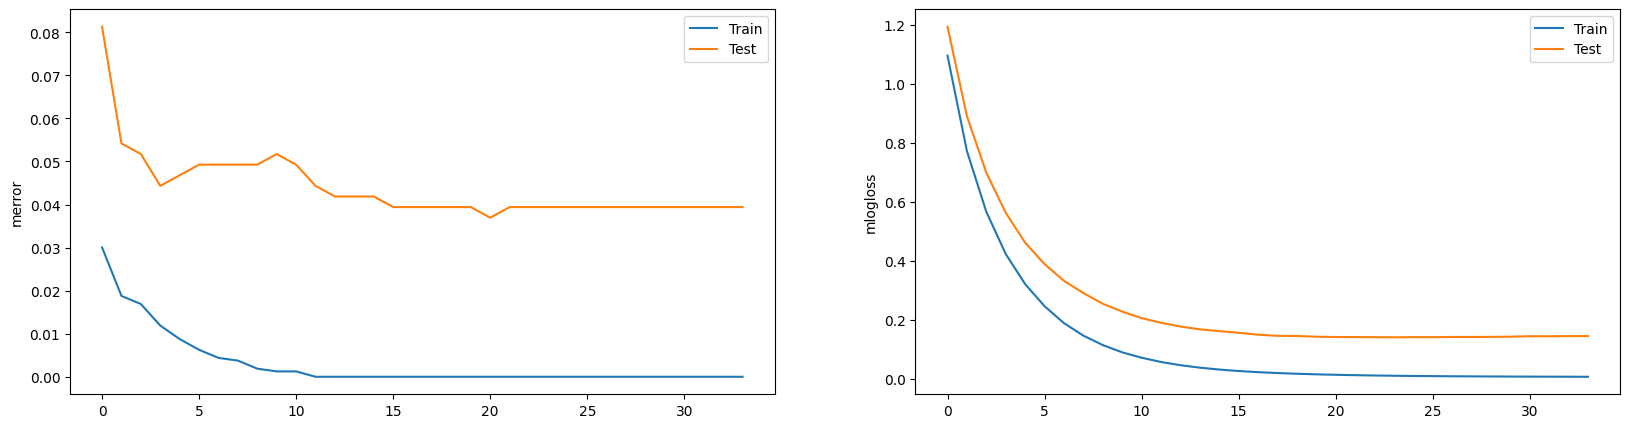

In [16]:
vae_xgboost = train_xgboost(vae_df, X_train, y_train, X_test, y_test)

In [17]:
y_pred = vae_xgboost.predict(X_test)

In [18]:
stats.append(prediction_stats("XGB_scVI", vae_xgboost, y_test, y_pred, vae_df.values[:, :-1], vae_df['target'].cat.codes.to_numpy()))

In [19]:
vae_xgboost.save_model("../results/02_mouse_integration/05_scVI_xgboost.json")

### 3.2. scANVI

In [20]:
lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi/")

INFO     File ../results/02_mouse_integration/scanvi/model.pt already downloaded                                   


In [21]:
lvae_df = pd.DataFrame(lvae.get_normalized_expression(return_mean=True))
lvae_df['target'] = lvae.adata.obs.ct
lvae_df.head()

,sox17,ppp1r42,arfgef1,prdm14,xkr9,msc,ube2w,gm7654,tmem70,ly96,...,stn1,gsto1,1700054a03rik,gm50273,habp2,ccdc186,afap1l2,pnlip,pnliprp2,target
SRX259148,1.499321e-08,7.591232e-08,0.000068,0.000003,0.000065,0.000326,0.000131,1.483101e-08,0.000298,0.000150,...,0.000185,0.005562,8.425851e-07,4.370481e-09,1.569241e-09,0.000072,4.824862e-08,1.690867e-09,0.000051,16C
SRX259191,1.535953e-07,3.323944e-08,0.000084,0.000012,0.000095,0.000061,0.000062,1.126642e-06,0.000531,0.000390,...,0.000336,0.002567,1.206273e-08,3.697671e-08,8.405232e-09,0.000134,1.122398e-06,5.098362e-07,0.000258,8C
SRX259121,2.234061e-10,1.818486e-07,0.000059,0.000002,0.000023,0.000644,0.000123,3.998329e-11,0.000119,0.000196,...,0.000069,0.001645,4.700184e-07,2.258681e-09,1.102188e-10,0.000037,5.974784e-09,1.568855e-09,0.000009,16C
SRX259140,8.150251e-08,4.920110e-08,0.000055,0.000010,0.000060,0.000158,0.000128,1.852338e-07,0.000286,0.000275,...,0.000263,0.004427,1.616031e-07,1.186041e-08,5.657514e-09,0.000073,3.052841e-07,3.905111e-08,0.000125,16C
SRX259161,2.039545e-07,1.044988e-07,0.000329,0.000031,0.000166,0.000001,0.000171,3.242764e-05,0.000807,0.000285,...,0.000279,0.000124,4.134634e-10,1.175266e-07,7.103967e-09,0.000540,9.310104e-05,2.019131e-06,0.000002,4C


In [22]:
X_train, y_train, X_test, y_test = train_test_split_by_group(lvae_df)

[0]	validation_0-merror:0.03504	validation_0-mlogloss:1.11435	validation_1-merror:0.16502	validation_1-mlogloss:1.35171
[1]	validation_0-merror:0.02566	validation_0-mlogloss:0.78891	validation_1-merror:0.12315	validation_1-mlogloss:1.04526
[2]	validation_0-merror:0.01815	validation_0-mlogloss:0.58309	validation_1-merror:0.11084	validation_1-mlogloss:0.85486
[3]	validation_0-merror:0.01314	validation_0-mlogloss:0.43796	validation_1-merror:0.09852	validation_1-mlogloss:0.72215
[4]	validation_0-merror:0.01064	validation_0-mlogloss:0.33298	validation_1-merror:0.10099	validation_1-mlogloss:0.62165
[5]	validation_0-merror:0.00688	validation_0-mlogloss:0.25603	validation_1-merror:0.09852	validation_1-mlogloss:0.54944
[6]	validation_0-merror:0.00501	validation_0-mlogloss:0.19739	validation_1-merror:0.09606	validation_1-mlogloss:0.49209
[7]	validation_0-merror:0.00250	validation_0-mlogloss:0.15305	validation_1-merror:0.09852	validation_1-mlogloss:0.44675
[8]	validation_0-merror:0.00250	validati

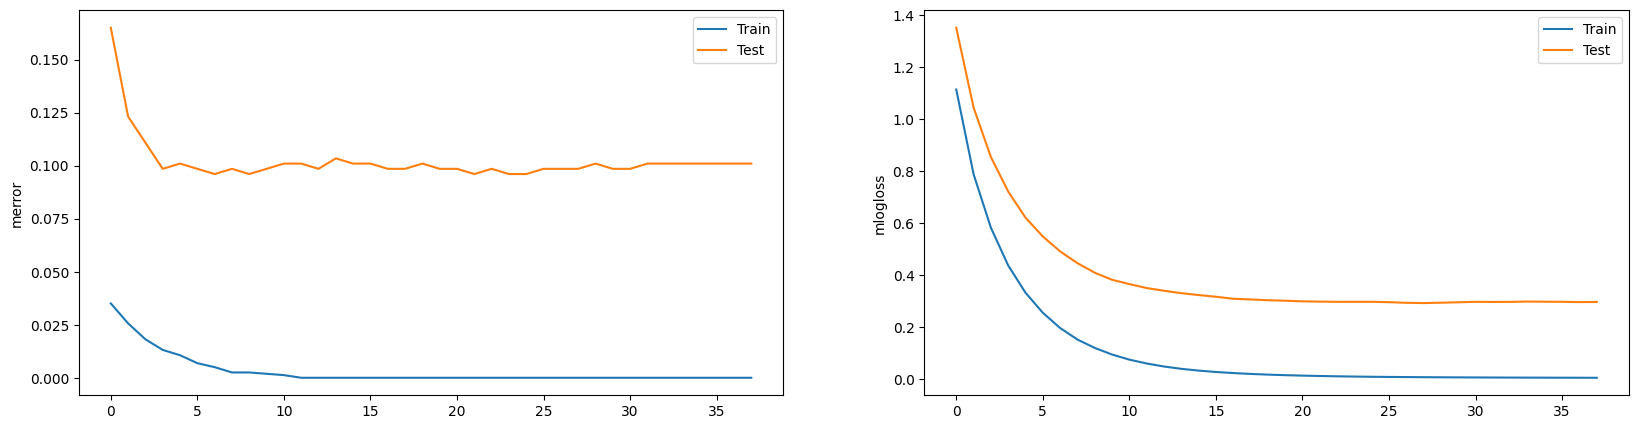

In [23]:
lvae_xgboost = train_xgboost(lvae_df, X_train, y_train, X_test, y_test)

In [24]:
y_pred = lvae_xgboost.predict(X_test)

In [25]:
stats.append(prediction_stats("XGB_scANVI", lvae_xgboost, y_test, y_pred, lvae_df.values[:, :-1], lvae_df['target'].cat.codes.to_numpy()))

In [26]:
lvae_xgboost.save_model("../results/02_mouse_integration/05_scANVI_xgboost.json")

### 3.3. scGEN

In [27]:
mscgen = scgen.SCGEN.load("../results/02_mouse_integration/scgen/")

INFO     File ../results/02_mouse_integration/scgen/model.pt already downloaded                                    


In [28]:
mscgen_df = pd.DataFrame(mscgen.get_decoded_expression(), 
                         index=mscgen.adata.obs_names, columns=mscgen.adata.var_names)
mscgen_df['target'] = mscgen.adata.obs['ct']
mscgen_df.head()

,sox17,ppp1r42,arfgef1,prdm14,xkr9,msc,ube2w,gm7654,tmem70,ly96,...,stn1,gsto1,1700054a03rik,gm50273,habp2,ccdc186,afap1l2,pnlip,pnliprp2,target
SRX259148,0.129524,-0.009126,0.580587,-0.027672,0.165227,0.593042,0.868470,-0.005957,1.724664,1.235015,...,1.047719,3.994854,0.026034,0.019212,-0.022841,0.752102,0.036959,0.001139,0.642708,16C
SRX259191,0.042759,-0.009889,0.608965,0.035671,0.257579,0.512698,0.708813,-0.007634,1.550365,1.364577,...,1.072520,3.394770,0.016012,0.020248,-0.048329,0.858443,0.036058,0.028643,0.485618,8C
SRX259121,-0.062429,-0.002099,0.516726,-0.141183,0.291033,0.251529,0.438559,-0.008837,1.417975,1.416850,...,0.471408,2.301015,0.038988,0.019344,0.005064,0.552338,-0.009445,-0.026622,0.361133,16C
SRX259140,-0.067408,-0.014072,0.476634,0.038267,0.143380,0.544186,0.797441,-0.009345,1.724418,1.436977,...,0.957134,3.538107,0.023010,0.025978,-0.022783,0.754117,0.064578,0.004726,0.577420,16C
SRX259161,0.009253,0.033485,1.305035,0.533173,-0.025159,0.184909,1.239522,0.022633,2.215558,1.189655,...,1.302740,1.088298,0.003135,0.037767,0.004102,1.716617,0.146538,0.081518,0.166842,4C


In [29]:
X_train, y_train, X_test, y_test = train_test_split_by_group(mscgen_df)

[0]	validation_0-merror:0.02753	validation_0-mlogloss:1.10220	validation_1-merror:0.07882	validation_1-mlogloss:1.17242
[1]	validation_0-merror:0.01815	validation_0-mlogloss:0.77531	validation_1-merror:0.07389	validation_1-mlogloss:0.88407
[2]	validation_0-merror:0.01252	validation_0-mlogloss:0.56490	validation_1-merror:0.06650	validation_1-mlogloss:0.69409
[3]	validation_0-merror:0.00876	validation_0-mlogloss:0.42008	validation_1-merror:0.06404	validation_1-mlogloss:0.56456
[4]	validation_0-merror:0.00688	validation_0-mlogloss:0.31672	validation_1-merror:0.06158	validation_1-mlogloss:0.46782
[5]	validation_0-merror:0.00501	validation_0-mlogloss:0.24033	validation_1-merror:0.06158	validation_1-mlogloss:0.40182
[6]	validation_0-merror:0.00375	validation_0-mlogloss:0.18417	validation_1-merror:0.06404	validation_1-mlogloss:0.35392
[7]	validation_0-merror:0.00125	validation_0-mlogloss:0.14143	validation_1-merror:0.06158	validation_1-mlogloss:0.31127
[8]	validation_0-merror:0.00063	validati

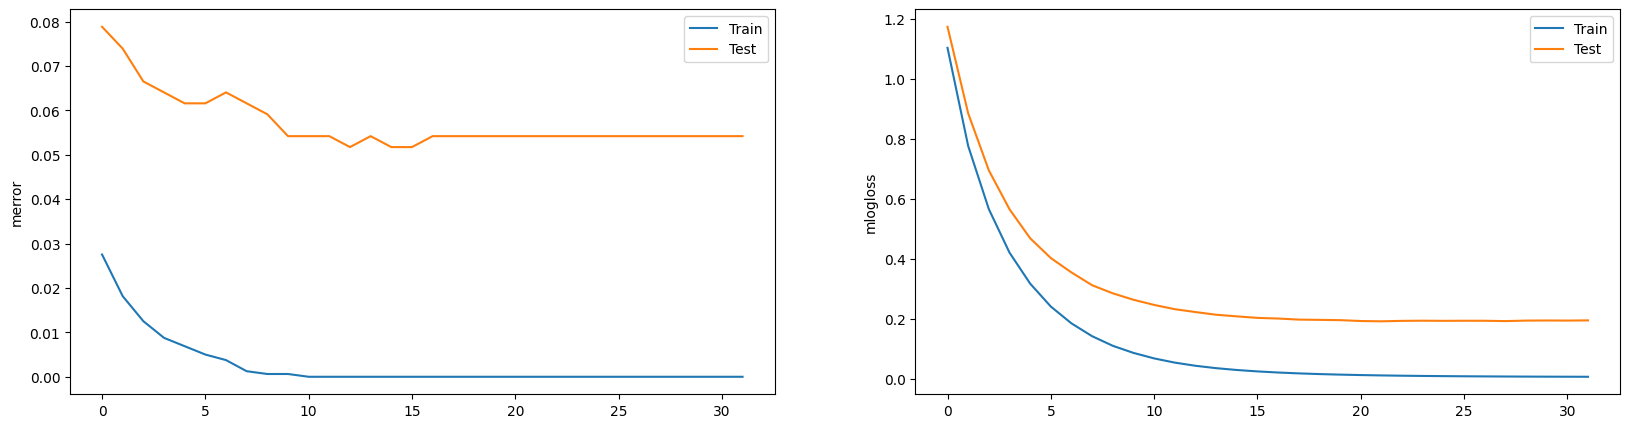

In [30]:
mscgen_xgboost = train_xgboost(mscgen_df, X_train, y_train, X_test, y_test)

In [31]:
stats.append(prediction_stats("XGB_scGEN", mscgen_xgboost, y_test, y_pred, mscgen_df.values[:, :-1], mscgen_df['target'].cat.codes.to_numpy()))

In [32]:
mscgen_xgboost.save_model("../results/02_mouse_integration/05_scGEN_xgboost.json")

## 4. Summary

In [33]:
stats_df = pd.DataFrame(stats, columns=['method', 'accuracy', 'balanced_accuracy', 'f1_micro', 'f1_macro', 'cv_accuracy']).set_index('method')
stats_df.to_csv("../results/05_mouse_classifier_stats.csv")

stats_df

,accuracy,balanced_accuracy,f1_micro,f1_macro,cv_accuracy
method,,,,,
scANVI,0.830339,0.649818,0.830339,0.634290,NaN
scANVI_ns15,0.793413,0.879503,0.793413,0.777624,NaN
XGB_scVI,0.960591,0.963041,0.960591,0.967656,0.935637
XGB_scANVI,0.901478,0.917235,0.901478,0.923392,0.920664
XGB_scGEN,0.901478,0.917235,0.901478,0.923392,0.942602


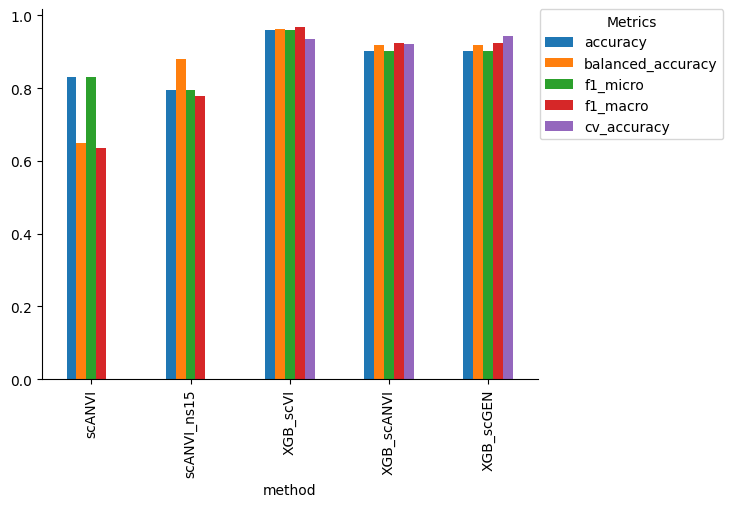

In [34]:
stats_df.plot(kind='bar')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(title='Metrics', bbox_to_anchor=(0.99, 1.02), loc='upper left')